**Project title:** Sectoral - Auto and transport

**Group#:** 27

## Overview
This project analyses holdings across several transportation & auto-focused mutual funds.

## How to run
1. Create and activate a virtual environment:

```powershell
python -m venv .venv; .venv\Scripts\Activate.ps1
```

2. Install dependencies:

```powershell
python -m pip install --upgrade pip
pip install -r requirements.txt
```

3. Open and run the notebook `Group27_Code.ipynb` in Jupyter:

```powershell
jupyter notebook
# then open the file and run cells (Kernel -> Restart & Run All)
```

## Environment and dependencies
- Fixed seed for reproducibility: `SEED = 42`. In Python cells set seeds with:

```python
import random
import numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
```

- Example `requirements.txt` (pinned versions):

```
pandas==1.5.2
numpy==1.23.5
matplotlib==3.6.2
jupyter==1.0.0
```

Notes:
- Use relative paths (the notebook expects `Holdings_Data/` next to this notebook).
- If data files exceed repository size limits, host them externally and load via raw URL.

## Contact
For questions about reproducibility or data access:

> Aalok Thakkar - 202301429@dau.ac.in


## Holdings Analysis
This notebook loads all CSVs in `Holdings_Data/`, standardises the columns, computes the requested features (Consensus Score, Conviction Metric, Normalized Holding %, Momentum Flag), then performs the commonality, concentration and momentum analyses requested by the project brief.

### Import and list files

- Purpose: import required libraries and list all CSV files in `Holdings_Data/`.
- Output: `files` will contain the CSV paths found; run to confirm available holdings files.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re

BASE = Path('Holdings_Data')
files = list(BASE.glob('*.csv'))
files

[WindowsPath('Holdings_Data/Aditya_Birla_Sun_Life_Transportation_And_Logistics_Fund.csv'),
 WindowsPath('Holdings_Data/Bandhan_Transportaion_And_Logistics_Fund.csv'),
 WindowsPath('Holdings_Data/Kotak_Transportation_Logistics_Fund.csv'),
 WindowsPath('Holdings_Data/stock_holdings_HDFC.csv'),
 WindowsPath('Holdings_Data/stock_holdings_ICICI_Prudential.csv'),
 WindowsPath('Holdings_Data/UTI_Transportation_Logistics_fund.csv')]

### Parsing helpers

- Purpose: convert percent and quantity strings to numeric values for later computation.
- Functions:
  - `parse_pct`: extracts a leading percent number from strings like `10.82% (Sep 2025)` and returns a float (e.g., `10.82`).
  - `parse_qty`: converts quantity strings like `1.12 L` or `30.00 k` to numeric counts (`L` -> 100,000; `k` -> 1,000).
- Output: numeric `_num` columns will be created in the loader cell.

In [15]:
# Helper parsers
def parse_pct(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # extract leading percent value
    m = re.search(r'(-?\d+\.?\d*)%?', s)
    if not m:
        return np.nan
    try:
        return float(m.group(1))
    except Exception:
        return np.nan

def parse_qty(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    # parse quantities like '1.12 L' or '30.00 k'
    s = s.replace(',', '')
    m = re.match(r'([\d\.]+)\s*([kKlL]?)', s)
    if not m:
        try:
            return float(s)
        except Exception:
            return np.nan
    val = float(m.group(1))
    suf = m.group(2).lower()
    if suf == 'k':
        val *= 1_000
    elif suf == 'l':
        val *= 100_000
    return val

### Load & standardize files

- Purpose: read each CSV, normalize column names, add a `fund` column, and parse numeric fields into `_num` columns.
- Actions performed:
  - Renames columns to a consistent schema.
  - Parses percent/quantity columns using the helper functions.
  - Concatenates all fund DataFrames into `combined`.
- Output: `combined` DataFrame (use `combined.head()` to preview).

In [55]:
# Load and standardize all holdings files into one DataFrame
dfs = []
for fp in files:
    fund_name = fp.stem
    df = pd.read_csv(fp)
    df.columns = [c.strip() for c in df.columns]
    # rename columns to consistent names
    col_map = {
        'Stock Invested in': 'Stock',
        'Stock Invested In': 'Stock',
        '% of Total Holdings': 'pct_of_total',
        'Value (Mn)': 'value_mn',
        'Value(Mn)': 'value_mn',
        '1M Change': '1m_change',
        '1Y Highest Holding': '1y_high',
        '1Y Lowest Holding': '1y_low',
        'Quantity': 'quantity',
        '1M Change in Qty': '1m_change_qty',
        'Sector': 'sector'
    }
    df = df.rename(columns=col_map)
    df['fund'] = fund_name
    # parse numeric columns (use .get to avoid KeyError if a column wasn't present after renaming)
    df['pct_of_total_num'] = df.get('pct_of_total').apply(parse_pct) if 'pct_of_total' in df.columns else np.nan
    df['1m_change_num'] = df.get('1m_change').apply(parse_pct) if '1m_change' in df.columns else np.nan
    df['1y_high_num'] = df.get('1y_high').apply(parse_pct) if '1y_high' in df.columns else np.nan
    df['1y_low_num'] = df.get('1y_low').apply(parse_pct) if '1y_low' in df.columns else np.nan
    df['value_mn_num'] = pd.to_numeric(df.get('value_mn', np.nan), errors='coerce')
    df['quantity_num'] = df.get('quantity').apply(parse_qty) if 'quantity' in df.columns else np.nan
    df['1m_change_qty_num'] = pd.to_numeric(df.get('1m_change_qty', 0), errors='coerce')
    dfs.append(df)

combined = pd.concat(dfs, ignore_index=True, sort=False)
combined.shape

combined.sample(10)

,Stock,sector,value_mn,pct_of_total,1m_change,1y_high,1y_low,quantity,1m_change_qty,fund,pct_of_total_num,1m_change_num,1y_high_num,1y_low_num,value_mn_num,quantity_num,1m_change_qty_num,Quantity (L),1M Change in Qty (L)
0,Mahindra & Mahindra Ltd.,Passenger cars & utility vehicles,1790.8,11.26%,0.21%,11.26%,10.19%,5.14 L,0.0,Aditya_Birla_Sun_Life_Transportation_And_Logis...,11.26,0.21,11.26,10.19,1790.8,514000.0,0.0,NaN,NaN
5,Hero Motocorp Ltd.,2/3 wheelers,803.0,5.05%,0.07%,5.46%,4.01%,1.45 L,0.0,Aditya_Birla_Sun_Life_Transportation_And_Logis...,5.05,0.07,5.46,4.01,803.0,145000.0,0.0,NaN,NaN
36,Bajaj Auto Ltd.,2/3 wheelers,907.0,5.23%,-0.13%,7.06% (Jan 2025),5.23% (Oct 2025),1.02 L,0.0,stock_holdings_HDFC,5.23,-0.13,7.06,5.23,907.0,102000.0,0.0,NaN,NaN
45,Tata Motors Passenger Vehicles Ltd.,Passenger cars & utility vehicles,1458.9,4.83%,-3.20%,8.82% (Mar 2025),4.83% (Oct 2025),NaN,NaN,stock_holdings_ICICI_Prudential,4.83,-3.20,8.82,4.83,1458.9,NaN,0.0,35.58,0.0
13,Bosch Ltd.,Auto components & equipments,335.2,5.09%,-0.14%,6.35%,4.93%,9.00 k,0.00,Bandhan_Transportaion_And_Logistics_Fund,5.09,-0.14,6.35,4.93,335.2,9000.0,0.0,NaN,NaN
54,InterGlobe Aviation Ltd.,Airline,2013.4,5.02%,-0.45%,6.46% (Mar 2025),5.02% (Oct 2025),3.58 L,-0.30 L,UTI_Transportation_Logistics_fund,5.02,-0.45,6.46,5.02,2013.4,358000.0,NaN,NaN,NaN
33,Bosch Ltd.,Auto components & equipments,1117.4,6.45%,-0.48%,8.16% (Jul 2025),5.4% (Jan 2025),30.00 k,0.0,stock_holdings_HDFC,6.45,-0.48,8.16,5.40,1117.4,30000.0,0.0,NaN,NaN
48,Hyundai Motor India Ltd.,Passenger cars & utility vehicles,1005.8,3.33%,-1.06%,4.39% (Sep 2025),2.26% (Dec 2024),NaN,NaN,stock_holdings_ICICI_Prudential,3.33,-1.06,4.39,2.26,1005.8,NaN,0.0,4.12,-1.0
12,Mahindra & Mahindra Ltd.,Passenger cars & utility vehicles,435.9,6.62%,0.09%,12.57%,6.53%,1.25 L,0.00,Bandhan_Transportaion_And_Logistics_Fund,6.62,0.09,12.57,6.53,435.9,125000.0,0.0,NaN,NaN
57,Hyundai Motor India Ltd.,Passenger cars & utility vehicles,1734.8,4.33%,0.51%,4.33% (Oct 2025),1.89% (Jan 2025),7.11 L,1.25 L,UTI_Transportation_Logistics_fund,4.33,0.51,4.33,1.89,1734.8,711000.0,NaN,NaN,NaN


## Data Cleaning

### Missing Values Analysis

In [ ]:
missing = combined.isna().sum().rename('missing_count').reset_index().rename(columns={'index':'column'})
missing['missing_pct'] = (missing['missing_count'] / len(combined) * 100).round(3)
from IPython.display import display
display(missing.sort_values('missing_pct', ascending=False))


### Imputation

In [ ]:

# Imputation (stock median -> global median) for main numeric columns
num_cols = ['pct_of_total_num','1m_change_num','1y_high_num','1y_low_num','value_mn_num','quantity_num','1m_change_qty_num']
for col in num_cols:
    if col in combined.columns:
        flag_col = col + '_imputed'
        combined[flag_col] = False
        medians = combined.groupby('Stock')[col].transform('median')
        mask = combined[col].isna()
        combined.loc[mask, col] = medians[mask]
        mask2 = combined[col].isna()
        if mask2.any():
            global_med = combined[col].median()
            combined.loc[mask2, col] = global_med
            combined.loc[mask2, flag_col] = True
        filled_by_stock = mask & (~combined[col].isna())
        combined.loc[filled_by_stock, flag_col] = True


### Feature engineering

- Purpose: compute analysis-ready features for each holding.
- Features created:
  - `consensus_score`: number of funds holding the stock.
  - `conviction_metric`: normalized position vs 1Y range: (current - 1Y low) / (1Y high - 1Y low).
  - `peer_mean_pct` and `normalized_holding_pct`: peer average and fund's overweight/underweight vs peer mean.
  - `momentum_flag`: 'Buy' / 'Sell' / 'Neutral' using 1M Change thresholds (>0.1%, <-0.1%).
- Output: a preview of `combined` with the new columns.

In [56]:
consensus = combined[combined['pct_of_total_num'].notna()].groupby('Stock')['fund'].nunique().rename('consensus_score')
combined = combined.merge(consensus, on='Stock', how='left')

# Conviction Metric
def conviction(row):
    hi = row['1y_high_num']
    lo = row['1y_low_num']
    cur = row['pct_of_total_num']
    if pd.isna(cur) or pd.isna(hi) or pd.isna(lo):
        return np.nan
    denom = (hi - lo)
    if denom == 0:
        return np.nan
    return (cur - lo) / denom

combined['conviction_metric'] = combined.apply(conviction, axis=1)

# Normalized Holding % (over/underweight vs peer average)
peer_mean = combined.groupby('Stock')['pct_of_total_num'].mean().rename('peer_mean_pct')
combined = combined.merge(peer_mean, on='Stock', how='left')
combined['normalized_holding_pct'] = combined['pct_of_total_num'] - combined['peer_mean_pct']

# Momentum flag based on 1M Change threshold of 0.1%
def momentum_flag(x):
    if pd.isna(x):
        return 'Neutral'
    if x > 0.1:
        return 'Buy'
    if x < -0.1:
        return 'Sell'
    return 'Neutral'

combined['momentum_flag'] = combined['1m_change_num'].apply(momentum_flag)

combined[['Stock','fund','sector','pct_of_total_num','1y_high_num','1y_low_num','consensus_score','conviction_metric','normalized_holding_pct','1m_change_num','momentum_flag']].sample(10)

,Stock,fund,sector,pct_of_total_num,1y_high_num,1y_low_num,consensus_score,conviction_metric,normalized_holding_pct,1m_change_num,momentum_flag
18,InterGlobe Aviation Ltd.,Bandhan_Transportaion_And_Logistics_Fund,Airline,2.99,5.16,2.82,5,0.072650,-1.792000,0.01,Neutral
45,Tata Motors Passenger Vehicles Ltd.,stock_holdings_ICICI_Prudential,Passenger cars & utility vehicles,4.83,8.82,4.83,1,0.000000,0.000000,-3.20,Sell
47,Eicher Motors Ltd.,stock_holdings_ICICI_Prudential,2/3 wheelers,4.34,7.61,4.34,4,0.000000,-2.680000,-1.94,Sell
48,Hyundai Motor India Ltd.,stock_holdings_ICICI_Prudential,Passenger cars & utility vehicles,3.33,4.39,2.26,4,0.502347,-1.550000,-1.06,Sell
4,Motherson Sumi Systems Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,Auto components & equipments,5.47,5.74,4.99,2,0.640000,1.215000,-0.01,Neutral
40,Mahindra & Mahindra Ltd.,stock_holdings_ICICI_Prudential,Passenger cars & utility vehicles,13.69,15.24,11.91,6,0.534535,4.270000,-0.29,Sell
27,InterGlobe Aviation Ltd.,Kotak_Transportation_Logistics_Fund,Airline,4.68,7.82,0.00,5,0.598465,-0.102000,-0.31,Sell
29,Great Eastern Shipping Co. Ltd.,Kotak_Transportation_Logistics_Fund,Shipping,3.30,3.30,0.00,1,1.000000,0.000000,0.11,Buy
31,Eicher Motors Ltd.,stock_holdings_HDFC,2/3 wheelers,9.26,10.50,8.64,4,0.333333,2.240000,-0.46,Sell
55,Bajaj Auto Ltd.,UTI_Transportation_Logistics_fund,2/3 wheelers,4.71,6.23,4.65,6,0.037975,0.263333,0.06,Neutral


### Commonality: top common stocks

- Purpose: count how many funds hold each stock to find commonly held names.
- Output:
  - `stock_counts`: number of funds per stock, sorted descending.
  - `top_common`: stocks held by the maximum number of funds.

In [11]:
stock_counts = combined.groupby('Stock')['fund'].nunique().rename('fund_count').reset_index()
stock_counts = stock_counts.sort_values('fund_count', ascending=False)
top_common = stock_counts[stock_counts['fund_count'] >= stock_counts['fund_count'].max()]
top_common.head()

,Stock,fund_count
2,Bajaj Auto Ltd.,6
13,Maruti Suzuki India Ltd.,6
12,Mahindra & Mahindra Ltd.,6


### Aggregate holding % across funds

- Purpose: sum `% of Total Holdings` for each stock across all funds to find collectively large exposures.
- Output: `agg_pct` lists stocks by combined percent exposure across funds.

In [12]:
# Aggregate Holding % across funds (sum of pct_of_total)
agg_pct = combined.groupby('Stock')['pct_of_total_num'].sum().rename('agg_pct_sum').reset_index().sort_values('agg_pct_sum', ascending=False)
agg_pct.head()

,Stock,agg_pct_sum
13,Maruti Suzuki India Ltd.,58.47
12,Mahindra & Mahindra Ltd.,56.52
5,Eternal Ltd.,32.51
8,Hero Motocorp Ltd.,31.27
4,Eicher Motors Ltd.,28.08


### Sector concentration (Count)

- Purpose: for each fund, take the top-5 holdings and count how often each sector appears across all funds' top-5 lists.
- Output: `sector_count` shows the frequency each sector appears in top-5 holdings.

In [21]:
top5_each = combined.sort_values(['fund','pct_of_total_num'], ascending=[True, False]).groupby('fund').head(5)
sector_count = top5_each['sector'].value_counts().rename_axis('sector').reset_index(name='count')
sector_count

,sector,count
0,Passenger cars & utility vehicles,13
1,E-retail/ e-commerce,5
2,2/3 wheelers,5
3,Auto components & equipments,4
4,Airline,3


### Sector concentration (Value)

- Purpose: sum `Value (Mn)` by sector across all funds to find which sectors hold the greatest total value.
- Output: `sector_value` lists sectors sorted by total value across funds.

In [8]:
# Sector concentration (Value): sum value_mn_num by sector across all funds
sector_value = combined.groupby('sector')['value_mn_num'].sum().rename('total_value_mn').reset_index().sort_values('total_value_mn', ascending=False)
sector_value.head()

,sector,total_value_mn
5,Passenger cars & utility vehicles,29888.4
0,2/3 wheelers,21669.9
4,E-retail/ e-commerce,7377.8
1,Airline,4992.6
2,Auto components & equipments,4322.2


### Momentum & Sentiment Analysis

- Purpose: identify strong positive and negative momentum moves and holdings near their 1Y highs.
- Outputs:
  - `pos_mom`: holdings with positive 1M Change (and positive qty change when available), sorted descending.
  - `neg_mom`: holdings with negative 1M Change (and negative qty change when available), sorted ascending.
  - `near_highs`: holdings where current `% of Total Holdings` is within 0.1% of the 1Y high.

In [13]:
# 3. Momentum & Sentiment Analysis
# Strong Positive Momentum: large positive 1M Change and positive qty change
pos_mom = combined[(combined['1m_change_num'] > 0)].copy()
pos_mom = pos_mom[pos_mom['1m_change_qty_num'] > 0] if '1m_change_qty_num' in pos_mom.columns else pos_mom
pos_mom = pos_mom.sort_values('1m_change_num', ascending=False)
pos_mom[['Stock','fund','1m_change_num','1m_change_qty_num','quantity_num']].head()

# Strong Negative Momentum: large negative 1M Change and negative qty change
neg_mom = combined[(combined['1m_change_num'] < 0)].copy()
neg_mom = neg_mom[neg_mom['1m_change_qty_num'] < 0] if '1m_change_qty_num' in neg_mom.columns else neg_mom
neg_mom = neg_mom.sort_values('1m_change_num')
neg_mom[['Stock','fund','1m_change_num','1m_change_qty_num','quantity_num']].head()

# Near 1Y Highs: where current pct within 0.1% of 1Y high
near_highs = combined[combined['pct_of_total_num'].notna() & combined['1y_high_num'].notna()].copy()
near_highs = near_highs[ (near_highs['1y_high_num'] - near_highs['pct_of_total_num']).abs() <= 0.1 ]
near_highs[['Stock','fund','pct_of_total_num','1y_high_num','conviction_metric']].sort_values('conviction_metric', ascending=False)

,Stock,fund,pct_of_total_num,1y_high_num,conviction_metric
0,Mahindra & Mahindra Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,11.26,11.26,1.000000
2,Maruti Suzuki India Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,8.80,8.80,1.000000
6,TVS Motor Company Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,4.86,4.86,1.000000
11,Hero Motocorp Ltd.,Bandhan_Transportaion_And_Logistics_Fund,7.16,7.16,1.000000
14,Hyundai Motor India Ltd.,Bandhan_Transportaion_And_Logistics_Fund,4.82,4.82,1.000000
15,Eicher Motors Ltd.,Bandhan_Transportaion_And_Logistics_Fund,4.79,4.79,1.000000
23,Swiggy Ltd.,Kotak_Transportation_Logistics_Fund,6.14,6.14,1.000000
29,Great Eastern Shipping Co. Ltd.,Kotak_Transportation_Logistics_Fund,3.30,3.30,1.000000
38,MRF Ltd.,stock_holdings_HDFC,3.20,3.20,1.000000
39,Apollo Tyres Limited,stock_holdings_HDFC,3.18,3.18,1.000000


## Visualizations

This section creates visual summaries of the computed features: distributions and top lists. Figures are saved to `outputs/figs` for quick review.

In [ ]:
# Plotting libraries and figure folder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# ensure reproducible styling
SEED = 42
import random
random.seed(SEED)
import numpy as _np
_np.random.seed(SEED)

FIG_OUT = Path('outputs') / 'figs'
FIG_OUT.mkdir(parents=True, exist_ok=True)


Found 60 rows in combined; figures will be saved to C:\Users\Aalok\OneDrive\Desktop\DAIICT\Sem 5\EDA_Project\Exploartory-Data-Analysis-\outputs\figs


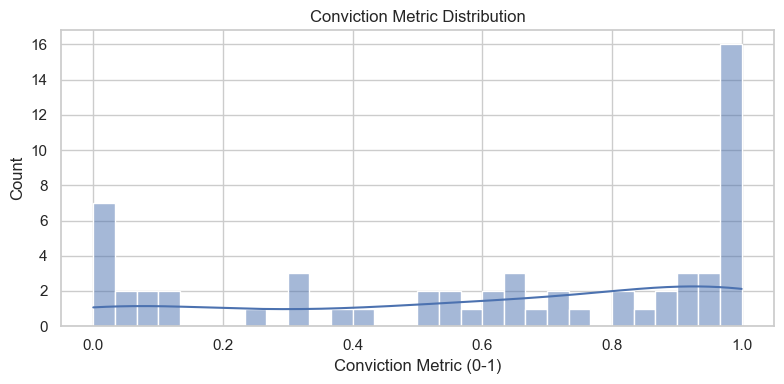

In [24]:
### Conviction metric distribution
plt.figure(figsize=(8,4))
sns.histplot(combined['conviction_metric'].dropna(), kde=True, bins=30, color='C0')
plt.title('Conviction Metric Distribution')
plt.xlabel('Conviction Metric (0-1)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'conviction_distribution.png', dpi=150)
plt.show()

C:\Users\Aalok\AppData\Local\Temp\ipykernel_4036\1150727209.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top15, y='Stock', x='fund_count', palette='viridis')


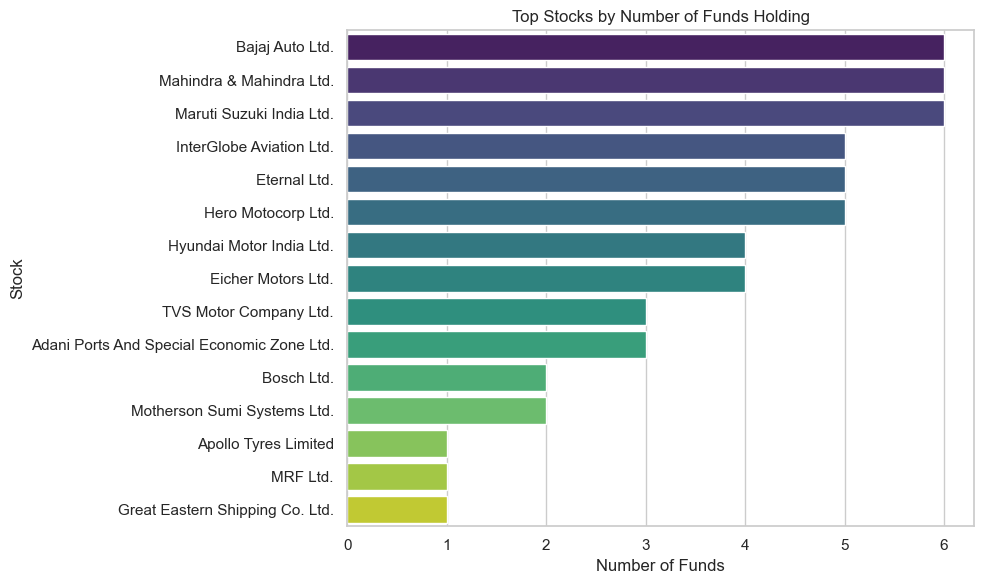

In [53]:
### Top common stocks (by funds holding)
top15 = stock_counts.sort_values('fund_count', ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(data=top15, y='Stock', x='fund_count', palette='viridis')
plt.title('Top Stocks by Number of Funds Holding')
plt.xlabel('Number of Funds')
plt.ylabel('Stock')
plt.tight_layout()
plt.savefig(FIG_OUT / 'top_stocks_fundcount.png', dpi=150)
plt.show()

C:\Users\Aalok\AppData\Local\Temp\ipykernel_4036\3311204703.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_agg, y='Stock', x='agg_pct_sum', palette='flare')


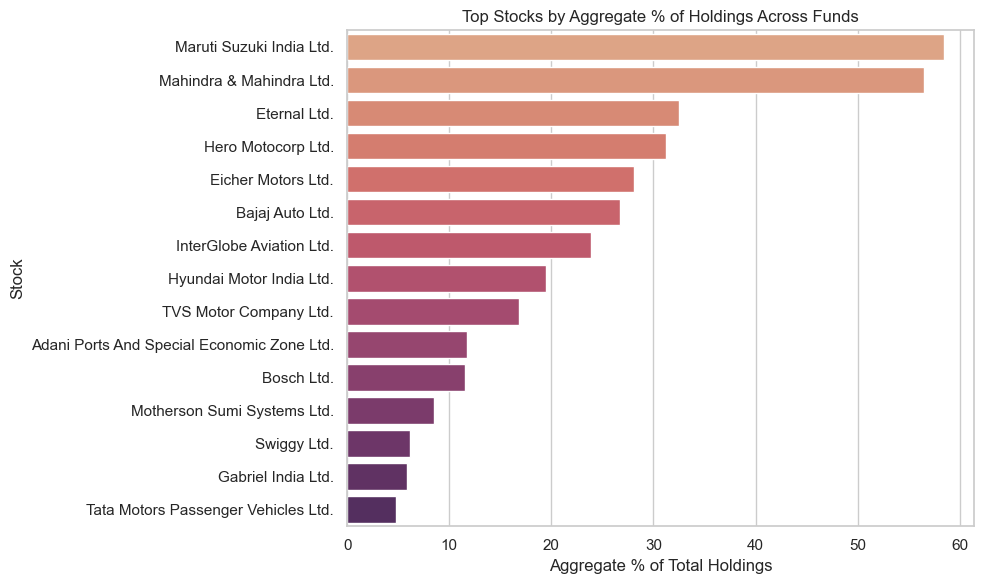

In [54]:
### Aggregate exposure: top stocks by total % across funds


top_agg = agg_pct.head(15)
plt.figure(figsize=(10,6))
sns.barplot(data=top_agg, y='Stock', x='agg_pct_sum', palette='flare')
plt.title('Top Stocks by Aggregate % of Holdings Across Funds')
plt.xlabel('Aggregate % of Total Holdings')
plt.ylabel('Stock')
plt.tight_layout()
plt.savefig(FIG_OUT / 'top_stocks_agg_pct.png', dpi=150)
plt.show()

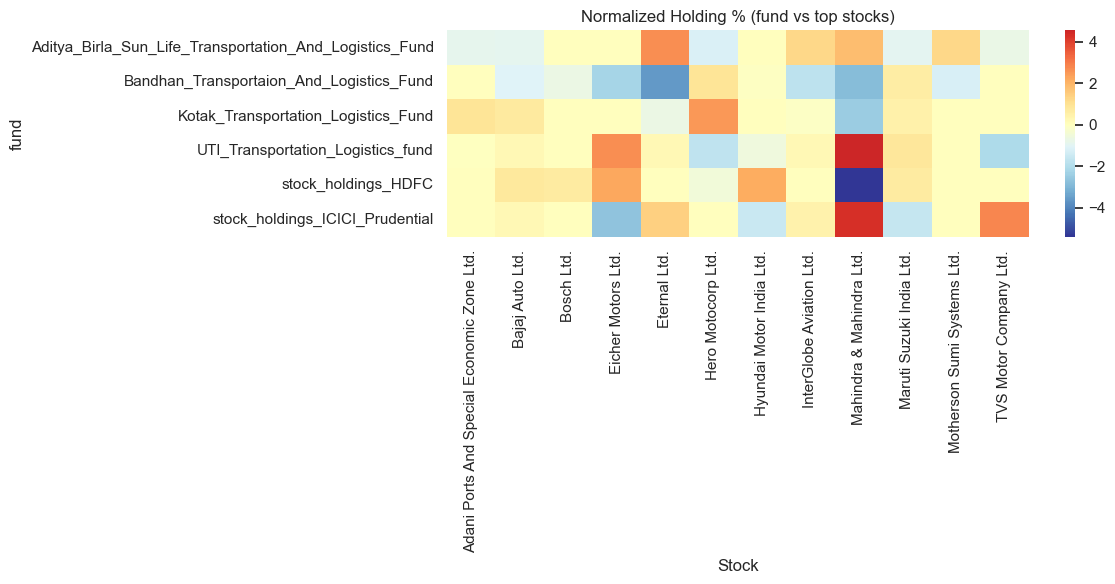

In [ ]:

top_stocks = agg_pct.head(12)['Stock'].tolist()
pivot = combined[combined['Stock'].isin(top_stocks)].pivot_table(index='fund', columns='Stock', values='normalized_holding_pct', aggfunc='mean').fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='RdYlBu_r', center=0, annot=False)
plt.title('Normalized Holding % (fund vs top stocks)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'heatmap_normalized_holding.png', dpi=150)
plt.show()

C:\Users\Aalok\AppData\Local\Temp\ipykernel_4036\3148294347.py:10: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data2, x='1m_change_num', y='1m_change_qty_num', levels=5, color='k', linewidths=1, alpha=0.6)


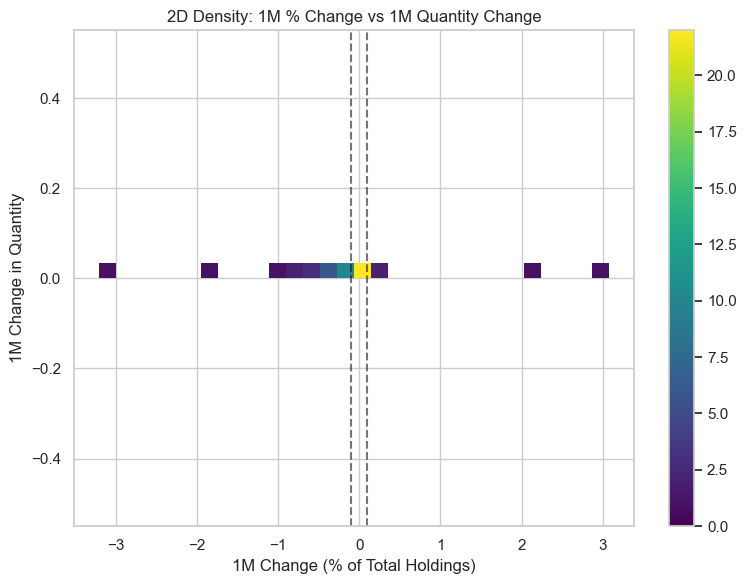

In [30]:
### 2D density: 1M Change vs Quantity change

# Use a 2D histogram + KDE contours to show where observations concentrate
data2 = combined[['1m_change_num','1m_change_qty_num','momentum_flag']].dropna(subset=['1m_change_num','1m_change_qty_num'])
plt.figure(figsize=(8,6))
# 2D histogram
sns.histplot(data=data2, x='1m_change_num', y='1m_change_qty_num', bins=30, pmax=0.9, cmap='viridis', cbar=True)
# overlay KDE contours if available
try:
    sns.kdeplot(data=data2, x='1m_change_num', y='1m_change_qty_num', levels=5, color='k', linewidths=1, alpha=0.6)
except Exception:
    pass

plt.axvline(0.1, color='k', linestyle='--', alpha=0.6)
plt.axvline(-0.1, color='k', linestyle='--', alpha=0.6)
plt.title('2D Density: 1M % Change vs 1M Quantity Change')
plt.xlabel('1M Change (% of Total Holdings)')
plt.ylabel('1M Change in Quantity')
plt.tight_layout()
plt.savefig(FIG_OUT / 'density_1m_pct_vs_qty.png', dpi=150)
plt.show()